In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load the dataset
df = pd.read_csv("WineQT.csv")
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


In [3]:
# Group quality: 0 = Low (<=5), 1 = Medium (=6), 2 = High (>=7)
df['quality_grouped'] = df['quality'].apply(lambda q: 0 if q <= 5 else (1 if q == 6 else 2))

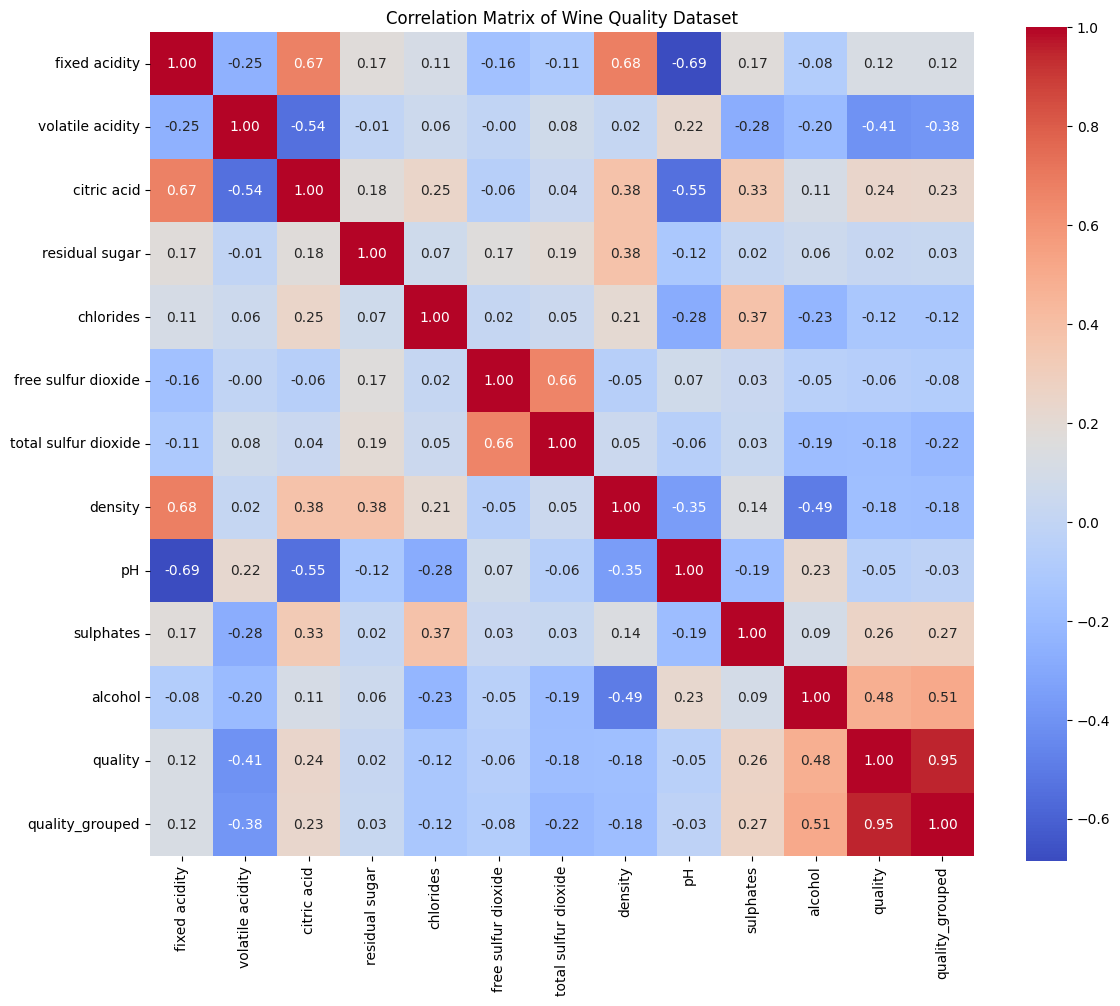

In [4]:
# Show correlation matrix to find top 4 features
correlation = df.corr()
top4 = correlation['quality'].drop('quality').abs().sort_values(ascending=False).head(4).index.tolist()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Wine Quality Dataset")
plt.tight_layout()
plt.show()

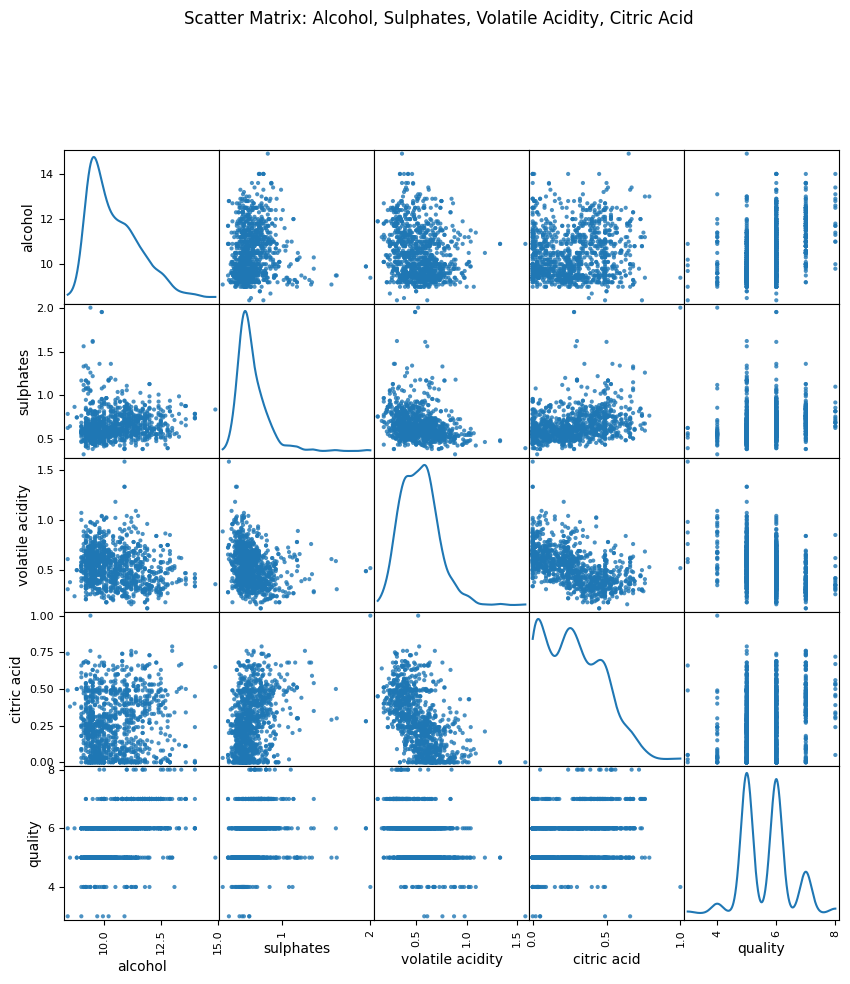

In [5]:
# Scatter matrix for top 4 features + original quality
selected_features = ['alcohol', 'sulphates', 'volatile acidity', 'citric acid']
scatter_matrix(df[selected_features + ['quality']], figsize=(10, 10), diagonal='kde', alpha=0.8)
plt.suptitle("Scatter Matrix: Alcohol, Sulphates, Volatile Acidity, Citric Acid", y=1.02)
plt.show()

In [21]:
# Prepare features and target
X = df.drop(columns=['quality', 'quality_grouped'])
y = df['quality_grouped']

In [22]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# PCA to retain ~95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [24]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [25]:
# Tune K (1 to 15)
k_values = list(range(1, 16))
cv_scores = []

In [26]:
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_pca, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

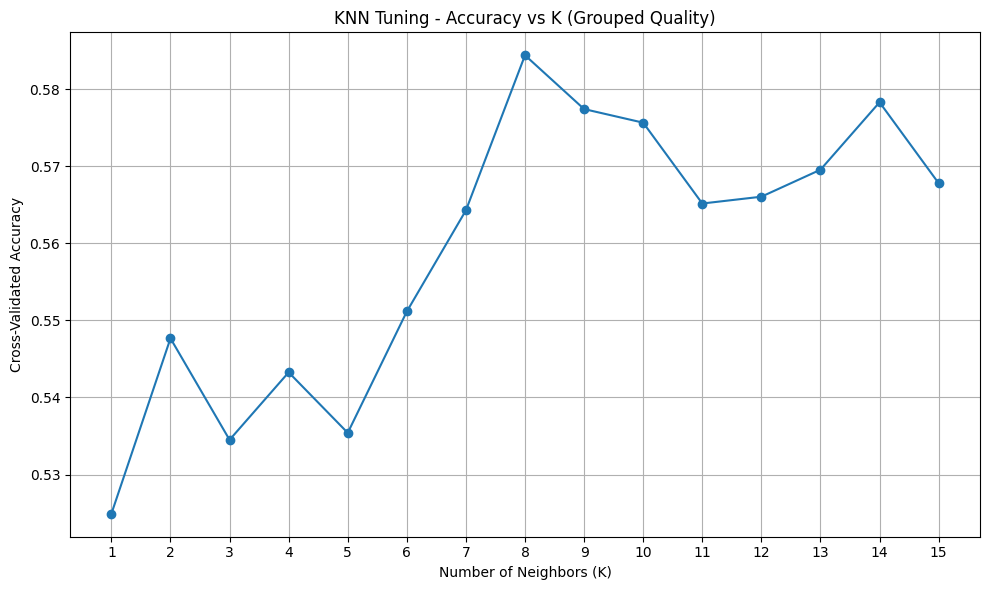

In [29]:
# Plot tuning results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Tuning - Accuracy vs K (Grouped Quality)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# Use best K
best_k = k_values[np.argmax(cv_scores)]
print(f"Best K: {best_k} with accuracy {cv_scores[np.argmax(cv_scores)]:.4f}")

Best K: 8 with accuracy 0.5844


In [31]:
# Train final KNN with best K
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

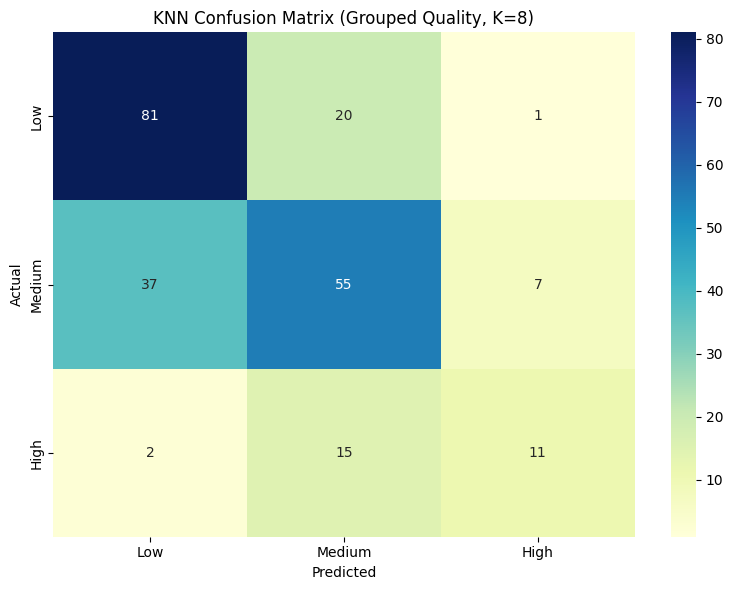

In [32]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title(f"KNN Confusion Matrix (Grouped Quality, K={best_k})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [34]:
# Classification report
print(f"KNN Classification Report (Grouped Quality, K={best_k}):\n")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium','High']))

KNN Classification Report (Grouped Quality, K=8):

              precision    recall  f1-score   support

         Low       0.68      0.79      0.73       102
      Medium       0.61      0.56      0.58        99
        High       0.58      0.39      0.47        28

    accuracy                           0.64       229
   macro avg       0.62      0.58      0.59       229
weighted avg       0.64      0.64      0.63       229

